<h1>Two bands model for LK99</h1>
We will import a tight-binding Hamiltonian as obtained from FPLO, which is stored in the file +hamdata and plot its bandstructure. Therefore we specify a set of high-symmetry points and their corresponding labels. Between each two consecutive high-symmetry points we pick 200 point on which the bands are calculated:

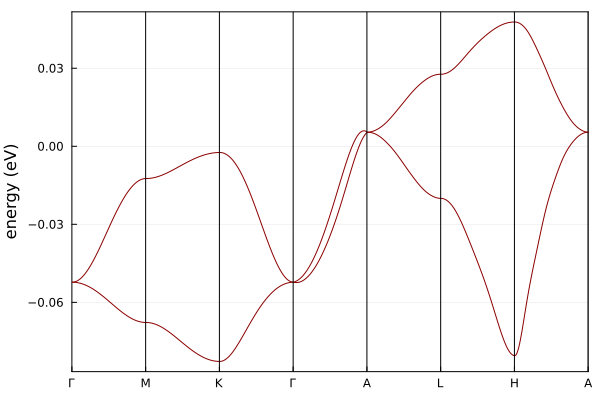

In [3]:
using LinearAlgebra, TightBindingToolBox, Plots, LaTeXStrings
filename = "/home/brass/Projekte/LK99/TB_Ham_2bands/+hamdata"
H = FPLO_import_TB(filename);
kpath = [[0,0,0], [1/2,-1/2,0],[2/3,-1/3,0],[0,0,0],[0,0,1/2],[1/2,-1/2,1/2],[2/3,-1/3,1/2],[0,0,1/2]]
label = [     "Γ",         "M",         "K",     "Γ",      "A",        "L",           "H",        "A"]
nkpts = 200

plot_Bandstructure(H,kpath,nkpts,label;c=:darkred,ylabel="energy (eV)")

<h2>Surface Fermi Arcs</h2>
If we cut the infinite crystal along the x=0 plane, we get a semi-infinite system with surface states. Due to the presence of Weyl-points these are topologically protected and are called Fermi arcs. To visualize them, we plot the spectral density of the yz-surface.  Therefore: 1) we calculate the maximum number of hoppings of the tight-binding Hamiltonian, this determines the minimal number of layers our semi-infinite system must have. 2) we define how many super layers our system will have (the larger the closer we are  to a semi-infinite system, but also the longer the calculation will take - 12*16 is goog enough here) and we calculate the spectral density on 100 k-points in each direction. We choose our chemical potential μ to be at the Fermi-level (E=0) and add a small imaginary pert from plotting. 3) we define basis vectors that span the yz-plane (called bx and by). bz defines the direction perpendicular to that plane, i.e. the direction in which the crystal is semi-infinite. 4) we calculate the spectral density using surface_spectral_density (note the transpose which is needed such that heatmap displays correctly) 

 16.627815 seconds (11.02 M allocations: 37.735 GiB, 5.91% gc time, 6.37% compilation time)


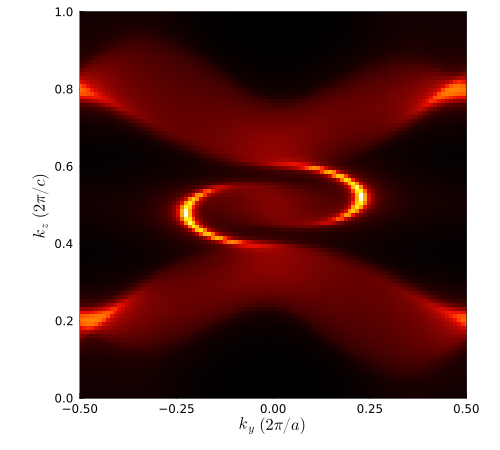

In [4]:
n_max_hop = max(maximum(map(x->x[1],keys(H.hoppings))),
    maximum(map(x->x[2],keys(H.hoppings))),
    maximum(map(x->x[3],keys(H.hoppings)))
)
n_super_layer = 12*16   #*8
n_kpts  = 100
μ =  0.0 +im*1E-3
bx = [0,1,0]
by = [0,0,1]
bz = [1,0,0]
A = @time surface_spectral_density(H,μ,bx,by,bz,n_super_layer,n_max_hop,n_kpts,-1/2,0)';

r1 = range(-1/2,1/2,n_kpts);
r2 = range(0,1,n_kpts);
plt =heatmap(r1,r2,A,
    c=:linear_kryw_0_100_c71_n256,  #:afmhot
    size=(500,450),
    aspect_ratio=1,
    xlabel=L"$k_y$ $(2\pi/a)$",
    ylabel=L"$k_z$ $(2\pi/c)$",
    xlims=(-1/2,1/2),
    ylims=(0,1),
    frame=:box,legend=false)

<h2>Berry Curvature </h2>

I visualize the curvature in the $k_z=0$ plane which contains a Weylpoint at $\Gamma$

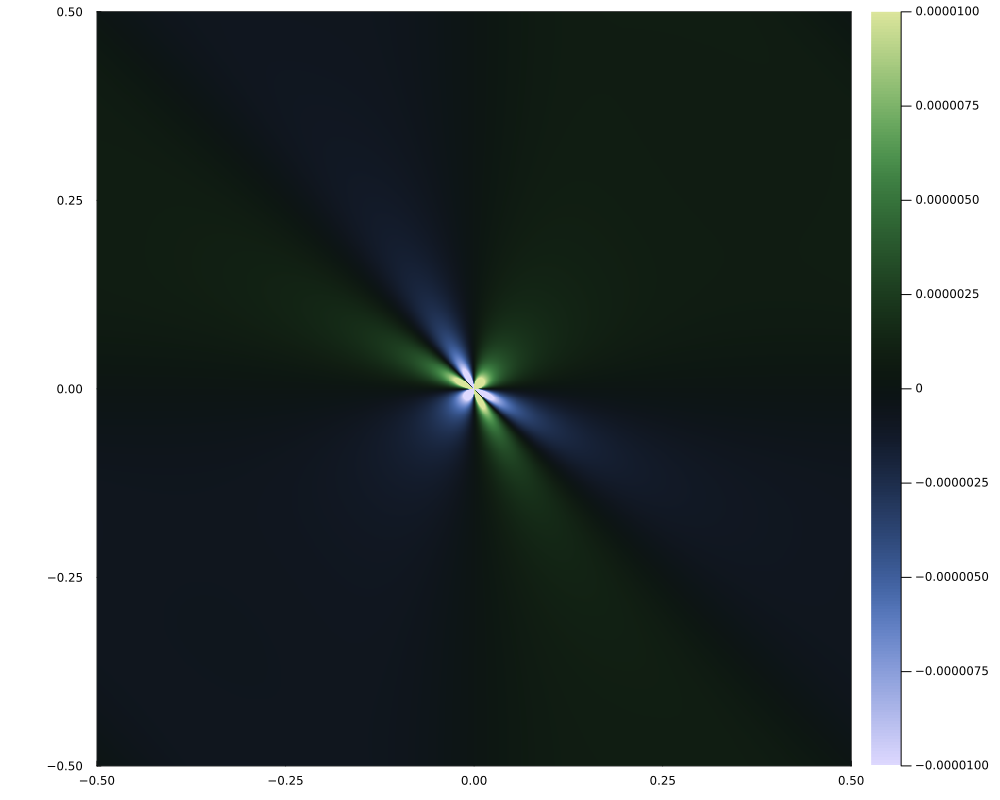

In [14]:
k0 = [0,0,0.0]
k1 = [1,0,0]
k2 = [0,1,0]
idx_band = 1
N=800
Ω = plot_curvature(H,idx_band,k0,k1,k2;N)
x = range(-1/2,1/2,N);
δ = 1E-5;


heatmap(x,x,Ω[1,2,:,:];aspect_ratio=1,size=(1000,800),
    c = :tofino,clim=(-δ,δ),frame=:box,
    xlims=(-1/2,1/2),ylims=(-1/2,1/2), legend=false)

<h1>Spin bands for LK99 </h1>

I performed a full relativistic calculation with FPLO for the same structure from Liang as above.$\newline$ I downfolded on the Cu $d_{\frac{5}{2}}\, m =\pm\frac{3}{2},\pm\frac{1}{2}$ orbitals.

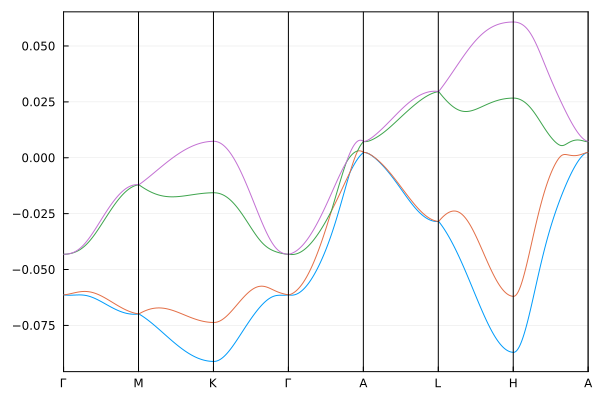

In [3]:
filename = "/home/brass/Projekte/LK99/TB_Ham_4spinbands/+hamdata"
H = FPLO_import_TB(filename);
kpath = [[0,0,0], [1/2,-1/2,0],[2/3,-1/3,0],[0,0,0],[0,0,1/2],[1/2,-1/2,1/2],[2/3,-1/3,1/2],[0,0,1/2]]
label = [     "Γ",         "M",         "K",     "Γ",      "A",        "L",           "H",        "A"]
nkpts = 200

plot_Bandstructure(H,kpath,nkpts,label)

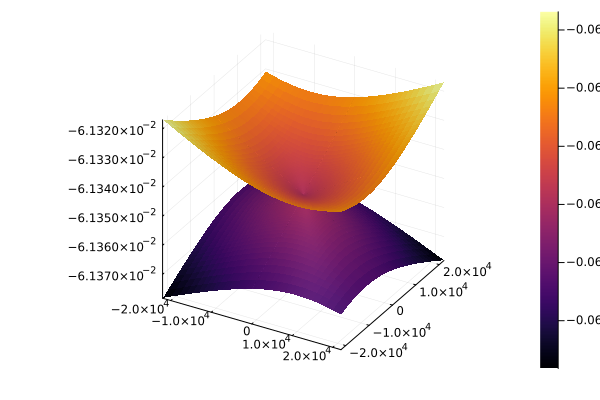

In [10]:
function get_surface_exp(H,idx,k0,kr,ks;δ=0.1)
    kx = append!(-exp.(collect(10:-δ:1)),[0.0],exp.(collect(1:δ:10)))
    kz = append!(-exp.(collect(10:-δ:1)),[0.0],exp.(collect(1:δ:10)))
    n = size(kx)[1]
    kmatX = kx * ones(n)'
    kmatZ = ones(n)*kz'
    surf = map((k1,k2)->real(eigvals(bloch_hamiltonian(H,k0 + k1*kr + k2*ks))[idx]),kmatX,kmatZ)
    return kmatX, kmatZ, surf
end

X,Y,S = get_surface_exp(H,1,[0,0,0],1E-7*[1,0,0],1E-7*[0,1,0])
plt=surface(X,Y,S)
X,Y,S = get_surface_exp(H,2,[0,0,0],1E-7*[1,0,0],1E-7*[0,1,0])
surface!(plt,X,Y,S)

<h2>Surface Fermi Arcs</h2>

 54.878672 seconds (279.72 M allocations: 92.344 GiB, 17.94% gc time)


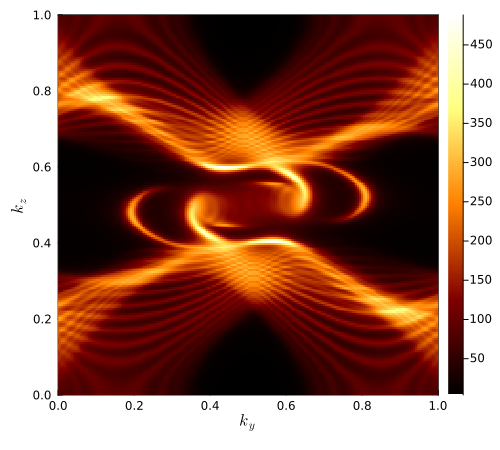

In [25]:
n_layer = 4*4   #*8
n_kpts  = 200
γ = im*1E-3
bx = [0,1,0]
by = [0,0,1]
bz = [1,0,0]
A = @time surface_spectral_density(H,γ,bx,by,bz,n_layer,n_kpts);

B = similar(A)
n2 = n_kpts ÷ 2
B[1:n2,:] = A'[n2+1:end,:]
B[n2+1:end,:] = A'[1:n2,:]
r = range(0,1,n_kpts);
heatmap(r,r,B,
    c=:afmhot,
    size=(500,450),
    aspect_ratio=1,
    xlabel=L"$k_y$",
    ylabel=L"$k_z$",
    xlims=(0,1),
    ylims=(0,1),
    frame=:box)